In [2]:
import sqlite3
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from datetime import datetime
import os


#PERMANENT DATABASE

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#IPHONE PRICE DECLARATION
###DEFINE IPHONE PRICES

In [4]:
iphone_models = {
    "iphone 11" : 35000,
    "iphone 11 pro" : 42000,
    "iphone 11 pro max" : 48000,

    "iphone 12" : 45000,
    "iphone 12 mini" : 40000,
    "iphone 12 pro" : 55000,
    "iphone 12 pro max" : 60000,

    "iphone 13" : 55000,
    "iphone 13 mini" : 50000,
    "iphone 13 pro" : 65000,
    "iphone 13 pro max" : 70000,

    "iphone 14" : 65000,
    "iphone 14 plus" : 70000,
    "iphone 14 pro" : 75000,
    "iphone 14 pro max" : 82000,

    "iphone 15" : 70000,
    "iphone 15 plus" : 75000,
    "iphone 15 pro" : 85000,
    "iphone 15 pro max" : 92000,

    "iphone 16" : 75000,
    "iphone 16 plus" : 80000,
    "iphone 16 pro" : 90000,
    "iphone 16 pro max" : 98000,

    "iphone 17": 80000,
    "iphone 17 plus": 85000,
    "iphone 17 pro": 95000,
    "iphone 17 pro max": 105000
}

###IPHONE VARIANTS

In [5]:
variants = {
    "4gb": 0,
    "6gb": 5000,
    "8gb": 10000,
    "12gb": 18000
}


###STORAGE OPTIONS

In [6]:
storage_options = {
    "128gb" : 0,
    "256gb" : 8000,
    "512gb" : 16000,
    "1tb" : 30000
}

###COLORS

In [7]:
colors = ["black", "white", "blue", "red", "green"]


###REFRESH RATE

In [9]:
refresh_rate = {
    "60hz" : 0,
    "120hz" : 7000
}


###ACCESSORIES

In [10]:

accessories = {
    "earpods" : 2000,
    "magsafe charger" : 3500,
    "apple care+" : 8000
}

###COMBO OFFERS

In [11]:
combo_offers = {
    frozenset(["earpods", "magsafe charger"]) : 1000,
    frozenset(["apple care+", "earpods"]) : 1500,
    frozenset(["apple care+", "magsafe charger"]) : 1500
}

###CHOOSE OPTIONS AVAILABLE

In [12]:
def get_choice(options, message):
    print("\nAvailable options : ")
    for opt in options:
        print("- ", opt)

    while True:
        choice = input(message).strip().lower()
        if choice in options:
            return choice
        else:
            print("❌ Invalid choice. Please select from the list.")


###CHOOSE COLOR

In [13]:
def get_color(colors):
    print("\nAvailable colors:")
    for c in colors:
        print("-", c)

    while True:
        choice = input("Enter color: ").strip().lower()
        if choice in colors:
            return choice
        else:
            print("❌ Invalid color. Try again.")


#CREATE DATABASE

In [14]:
db_path = "/content/drive/MyDrive/Applelytics_DB/applelytics.db"
conn = sqlite3.connect(db_path)


In [15]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print("Tables in DB:", cursor.fetchall())

conn.close()


Tables in DB: [('orders',), ('sqlite_sequence',)]


In [16]:
def create_database():
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS orders (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT,
        model TEXT,
        variant TEXT,
        storage TEXT,
        color TEXT,
        refresh_rate TEXT,
        accessories TEXT,
        discount REAL,
        total_price REAL
    )
    """)

    conn.commit()
    conn.close()


###SAVE TO SQLITE DATABASE

In [17]:
def save_to_database(order):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # FORCE TABLE CREATION (Safety Layer)
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS orders (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        date TEXT,
        model TEXT,
        variant TEXT,
        storage TEXT,
        color TEXT,
        refresh_rate TEXT,
        accessories TEXT,
        discount REAL,
        total_price REAL
    )
    """)

    cursor.execute("""
    INSERT INTO orders(date, model, variant, storage, color, refresh_rate, accessories, discount, total_price)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        order["date"],
        order["model"],
        order["variant"],
        order["storage"],
        order["color"],
        order["refresh_rate"],
        order["accessories"],
        order["discount"],
        order["total_price"]
    ))

    conn.commit()
    conn.close()


###SAVE TO CSV FILE

In [18]:
def save_to_csv(order):
  df = pd.DataFrame([order])

  df.to_csv(
      "projectapple_orders.csv",
      mode = "a",
      index = False,
      header = not pd.io.common.file_exists("projectapple_orders.csv")
  )

###PLACE ORDER

In [19]:
def place_order():

    model = get_choice(iphone_models, "Enter iphone Model : ")
    variant = get_choice(variants, "Enter RAM Variant : ")
    storage = get_choice(storage_options, "Enter Storage Option : ")
    hertz = get_choice(refresh_rate, "Enter Refresh Rate : ")
    color = get_color(colors)

    base_price = (
        iphone_models[model]
        + variants[variant]
        + storage_options[storage]
        + refresh_rate[hertz]
    )

    selected_accessories = []
    accessory_cost = 0

    print("\nAvailable Accessories : ")
    for acc, price in accessories.items():
        print(f"- {acc} → ₹{price}")

    while True:
        acc_input = input("Enter accessory name (or type 'done'): ").strip().lower()

        if acc_input == "done":
            break
        elif acc_input in accessories:
            selected_accessories.append(acc_input)
            accessory_cost += accessories[acc_input]
        else:
            print("Invalid accessory.")

    discount = 0
    for combo, disc in combo_offers.items():
        if combo.issubset(selected_accessories):
            discount += disc

    total_price = base_price + accessory_cost - discount

    current_date = datetime.now().strftime("%d-%m-%Y")

    order = {
        "date": current_date,
        "model": model,
        "variant": variant,
        "storage": storage,
        "color": color,
        "refresh_rate": hertz,
        "accessories": ", ".join(selected_accessories),
        "discount": discount,
        "total_price": total_price
    }

    save_to_database(order)
    save_to_csv(order)

    print("\n✅ Order Placed Successfully!")
    print(f"Total Price: ₹{total_price}")


###LOAD DATA FROM DATABASE

In [20]:
def load_data():
    conn = sqlite3.connect(db_path)

    df = pd.read_sql_query("SELECT * FROM orders", conn)

    conn.close()
    return df


###ANALYTICS FUNCTION

In [21]:
def analyze_data():
  df = load_data()

  if df.empty:
    print("No Orders Found.")
    return
  print("\n📊 APPLELYTICS REPORT")
  print("-" * 30)

  #Total Revenue
  total_revenue = df["total_price"].sum()
  print(f"💰 Total Revenue: ₹{total_revenue}")

  #Average Order Value
  avg_order = df["total_price"].mean()
  print(f"📈 Average Order Value: ₹{round(avg_order,2)}")

  # Most Sold Model
  top_model = df["model"].value_counts().idxmax()
  print(f"🏆 Most Sold Model: {top_model}")


#VISUALIZATION

  #Sales Chart (MODEL WISE)
  model_sales = df["model"].value_counts()
  plt.figure()
  model_sales.plot(kind = 'bar')
  plt.title("MODEL SALES COUNT")
  plt.xlabel("MODEL")
  plt.ylabel("NUMBER OF SALES")
  plt.xticks(rotation = 45)
  plt.show()

  print('\n\n')

  #STORAGE POPULARITY PIE CHART
  storage_sales = df["storage"].value_counts()

  plt.figure()
  storage_sales.plot(kind = "pie", autopct = "%1.1f%%")
  plt.title("STORAGE POPULARITY")
  plt.ylabel("")
  plt.show()

#INPUT DATA TO PLACE YOUR ORDER


Available options : 
-  iphone 11
-  iphone 11 pro
-  iphone 11 pro max
-  iphone 12
-  iphone 12 mini
-  iphone 12 pro
-  iphone 12 pro max
-  iphone 13
-  iphone 13 mini
-  iphone 13 pro
-  iphone 13 pro max
-  iphone 14
-  iphone 14 plus
-  iphone 14 pro
-  iphone 14 pro max
-  iphone 15
-  iphone 15 plus
-  iphone 15 pro
-  iphone 15 pro max
-  iphone 16
-  iphone 16 plus
-  iphone 16 pro
-  iphone 16 pro max
-  iphone 17
-  iphone 17 plus
-  iphone 17 pro
-  iphone 17 pro max
Enter iphone Model : IPHONE 12

Available options : 
-  4gb
-  6gb
-  8gb
-  12gb
Enter RAM Variant : 12gb

Available options : 
-  128gb
-  256gb
-  512gb
-  1tb
Enter Storage Option : 512gb

Available options : 
-  60hz
-  120hz
Enter Refresh Rate : 120hz

Available colors:
- black
- white
- blue
- red
- green
Enter color: blue

Available Accessories : 
- earpods → ₹2000
- magsafe charger → ₹3500
- apple care+ → ₹8000
Enter accessory name (or type 'done'): done

✅ Order Placed Successfully!
Total Price: ₹8

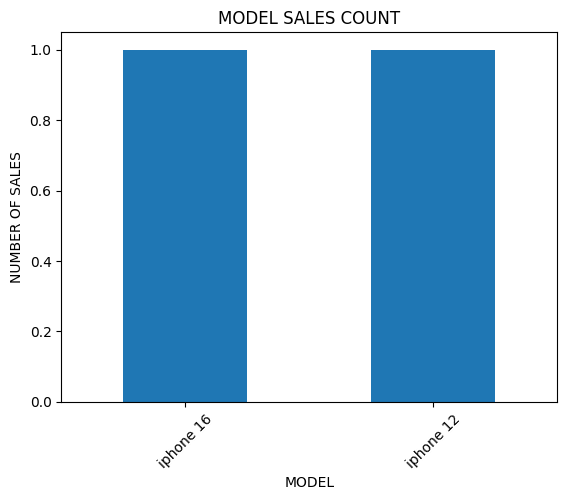

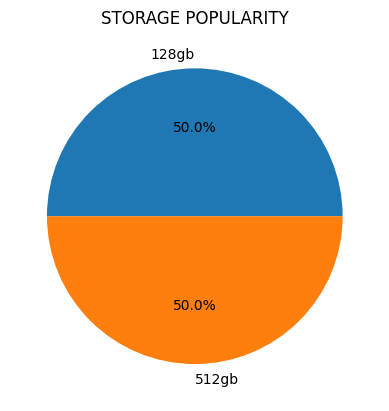

In [22]:
create_database()
place_order()
analyze_data()

[('iphone_orders',), ('sqlite_sequence',), ('orders',)]
